# Figure 4 and S4

Noteook to reproduce figure panels from Figure 4 and S4 in Yang\*, Jones\*, et al _bioRxiv_ 2021.

In [2]:
import os
import sys

from bokeh import palettes
import colorcet as cc
import ete3
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy
from tqdm.auto import tqdm

from cassiopeia.Analysis import small_parsimony
from cassiopeia.TreeSolver.Node import Node

sys.path.append('scripts')
import compute_plasticity_indices
import utilities

In [3]:
NUM_CELLS_THRESH = 100
PERCENT_UNIQUE_THRESH = 0.05
PERCENT_UNSATURATED_TARGETS_THRESH = 0.2
CLUSTER_PROP_THRESH = 0.025

data_directory = "/path/to/KPTracer-Data/"
adata = sc.read_h5ad(f'{data_directory}/expression/adata_processed.nt.h5ad')
sigscores = pd.read_csv("../Figure3_S3/data/signature_scores_sgNT.tsv", sep='\t', index_col = 0)


tumor_clone_statistics = pd.read_csv(f'{data_directory}/tumor_statistics.tsv', sep='\t', index_col = 0)

filtered = tumor_clone_statistics[(tumor_clone_statistics['NumCells'] < NUM_CELLS_THRESH) | 
                                  (tumor_clone_statistics['PercentUnique'] <= PERCENT_UNIQUE_THRESH) |
                                 (tumor_clone_statistics['PercentUnsaturatedTargets'] <= PERCENT_UNSATURATED_TARGETS_THRESH)].index

In [4]:
adata.obs['FitnessSignature'] = sigscores.loc[adata.obs_names, 'FitnessSignature']

### Evaluate cluster entropy on tumors - Figure S4A, B

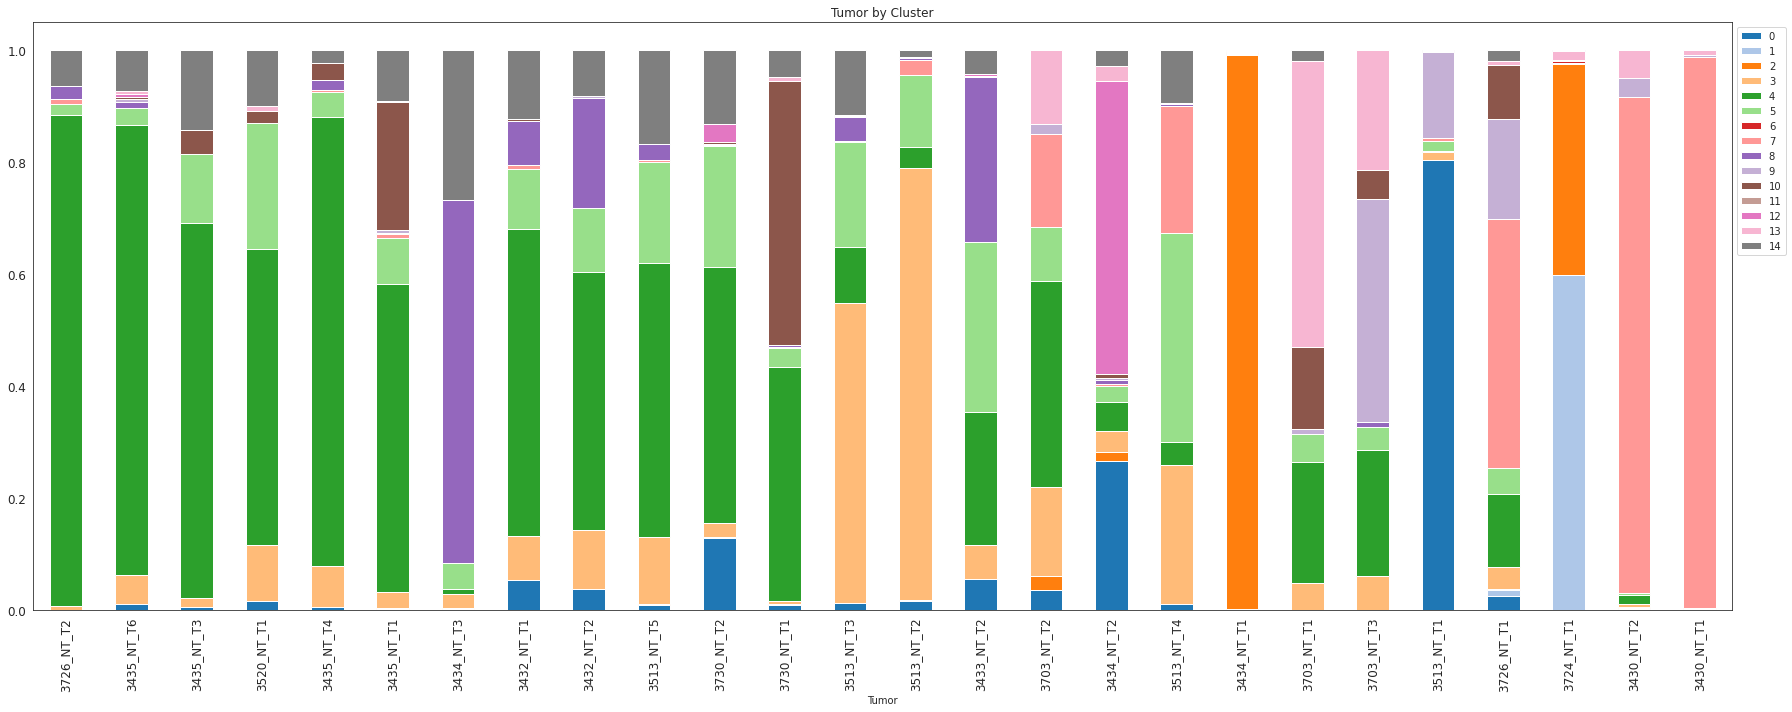

In [14]:
from matplotlib import colors

def tree_exists(tumor):
    
    filepath = f'{data_directory}/trees/{tumor}_tree.nwk'
    return os.path.exists(filepath)

fitness_signatures = {}

fitness_signatures = adata.obs.groupby("Tumor").agg({'FitnessSignature': 'mean'})

x = adata.obs.groupby(by = ['Tumor', 'leiden_sub']).size() / adata.obs.groupby(by = 'Tumor').size()
piv = x.unstack()

piv[piv.isna()] = 0

clust_colors = palettes.Category20[len(adata.obs['leiden_sub'].unique())]
clust_color_map = colors.ListedColormap(clust_colors)
    
piv = x.unstack()
_ord = fitness_signatures.sort_values(by='FitnessSignature').index.values
_ord = [t for t in _ord if t != 'nan' and t.split("_")[2][0] == 'T' and tree_exists(t)]
ax = piv.loc[_ord].plot(kind='bar', stacked=True, figsize = (25, 10),
                                    colormap=clust_color_map, fontsize=12)
ax.legend(bbox_to_anchor=(1,1))
ax.grid(False)
plt.title("Tumor by Cluster")
plt.tight_layout()
plt.show()

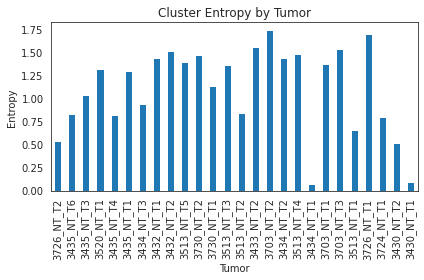

In [15]:

def compute_entropy(values):
    
    counts = values.value_counts()
    return scipy.stats.entropy(counts)

tumor_entropy = adata.obs.groupby('Tumor').agg({'leiden_sub': compute_entropy})

_ord = fitness_signatures.sort_values(by='FitnessSignature').index.values
_ord = [t for t in _ord if t != 'nan' and t.split("_")[2][0] == 'T' and tree_exists(t)]

tumor_entropy.loc[_ord].plot(kind='bar', legend=False)
plt.xlabel("Tumor")
plt.ylabel("Entropy")
plt.title("Cluster Entropy by Tumor")
plt.tight_layout()


### Compute tumor-level plasticity scores & compare to fitness - Figure 3G

In [16]:
tumor_plasticity = {}

FILTER_THRESH = 0.025

for tumor in _ord:
    
    fp = f'{data_directory}/trees/{tumor}_tree.nwk'
    tree = ete3.Tree(fp, 1)

    cm = pd.read_csv(f'{data_directory}/trees/{tumor}_character_matrix.txt', sep='\t', index_col = 0)
    cm = cm.replace("-", "-1").astype(int)

    keep_cells = np.intersect1d(tree.get_leaf_names(), adata.obs_names)
    
    obs_counts = adata.obs.loc[keep_cells].groupby('leiden_sub').agg({'leiden_sub': 'count'})
    
    filter_thresh = FILTER_THRESH*len(keep_cells)
    
    keep_vals = obs_counts[obs_counts['leiden_sub'] > filter_thresh].index.values

    tumor_obs = adata.obs.loc[keep_cells, 'leiden_sub']

    filt = tumor_obs.apply(lambda x: x in keep_vals)
    tumor_obs = tumor_obs.loc[filt]

    keep_cells = np.intersect1d(tumor_obs.index.values, keep_cells)

    tree.prune(keep_cells)
    tree = utilities.collapse_unifurcations(tree)
    
    graph = utilities.ete3_to_nx(tree, cm)
    
    #convert graph names to Nodes
    mapping = {}
    for n in graph:
        mapping[n] = Node(n)

    graph = nx.relabel_nodes(graph, mapping)

    graph = small_parsimony.assign_labels(graph, adata.obs['leiden_sub'])
    graph = utilities.preprocess_exhausted_regions(graph, sigma = adata.obs['leiden_sub'].unique())
    graph = small_parsimony.fitch_hartigan(graph)
    parsimony = small_parsimony.score_parsimony(graph)
    
    tumor_plasticity[tumor] = (parsimony / len(graph.edges()))
    

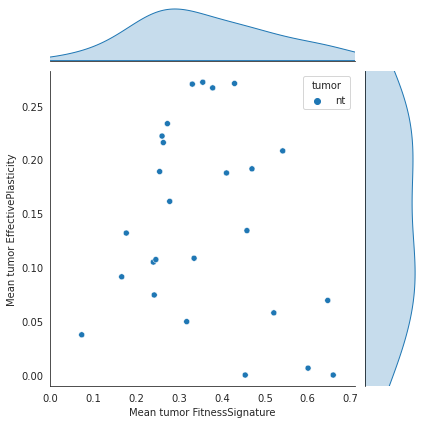

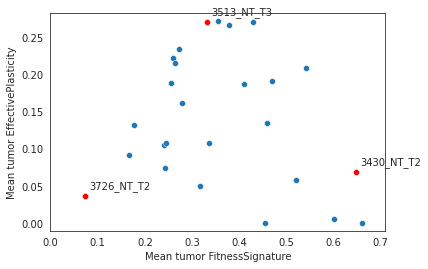

In [20]:
plasticities = np.array([tumor_plasticity[tumor] for tumor in tumor_plasticity.keys()])
fitnesses = np.array([fitness_signatures.loc[tumor, 'FitnessSignature'] for tumor in tumor_plasticity.keys()])

fitnesses = list(map(lambda x: (x - np.min(fitnesses) / (np.max(fitnesses) - np.min(fitnesses))), fitnesses))
# start with a square Figure

joint_df = pd.DataFrame([fitnesses, plasticities], columns = tumor_plasticity.keys()).T
joint_df.columns = ['Mean tumor FitnessSignature', 'Mean tumor EffectivePlasticity']
joint_df['tumor'] = 'nt'

joint_df['tumor'] = joint_df['tumor'].astype('category')

g = sns.jointplot(data=joint_df, x = 'Mean tumor FitnessSignature', y = 'Mean tumor EffectivePlasticity', hue='tumor', kind='scatter',
                  height = 6,
                  ylim=(-0.01, np.max(plasticities) + 0.01),
                  xlim = (0, np.max(fitnesses)+0.05))
plt.show()

g = sns.scatterplot(data=joint_df, x = 'Mean tumor FitnessSignature', y = 'Mean tumor EffectivePlasticity')
sns.scatterplot(data=joint_df.loc[['3726_NT_T2', '3513_NT_T3', '3430_NT_T2']], color='red', x = 'Mean tumor FitnessSignature', y = 'Mean tumor EffectivePlasticity')
plt.xlim((0, np.max(fitnesses)+0.05))
plt.ylim((-0.01, np.max(plasticities) + 0.01))

for i, tumor in zip(range(len(fitnesses)), tumor_plasticity.keys()):
    if tumor in ['3726_NT_T2', '3513_NT_T3', '3430_NT_T2']:
        g.annotate(tumor, (fitnesses[i]+0.01, plasticities[i]+0.01))

### Compute single-cell plasticity scores - Figure 4C-F

Single-cell plasticity scores were computed with the script `./scripts/compute_plasticity_indices.py`

In [5]:
plasticity_indices = pd.read_csv("./data/plasticity_scores.tsv", sep='\t', index_col = 0)

/home/eecs/mattjones/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


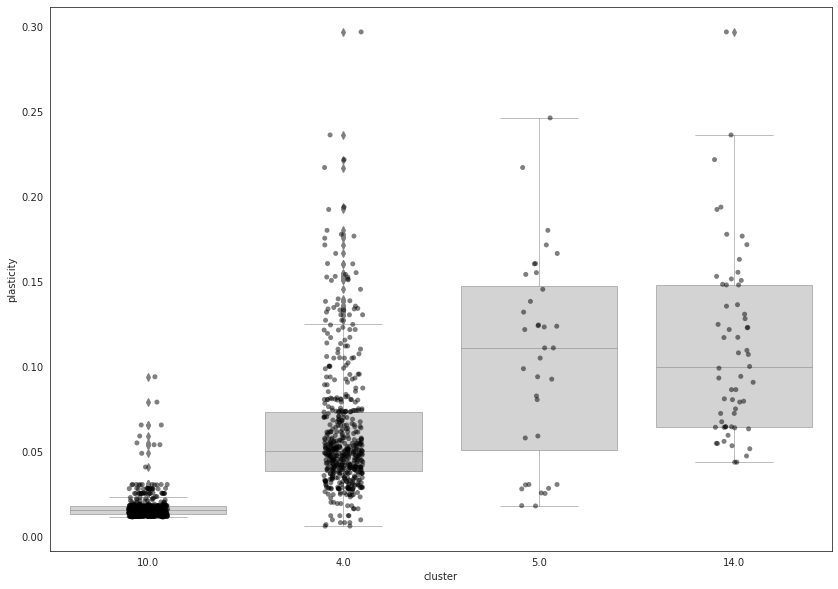

In [8]:
tumor = '3730_NT_T1'
FILTER_PROP = 0.025

kii = np.intersect1d(plasticity_indices.index.values, adata[adata.obs['Tumor'] == tumor,:].obs_names)
sc_plasticity = plasticity_indices.loc[kii, 'scPlasticity'].to_dict()
    
cluster_to_plasticities = pd.DataFrame(columns = ['cluster', 'plasticity'])
for cluster, g in adata[kii].obs.groupby("leiden_sub"):
    indices = g.index.values
    vals = [sc_plasticity[index] for index in indices]
    _df = pd.DataFrame([[int(cluster)]*len(vals), vals], index=['cluster', 'plasticity']).T
    cluster_to_plasticities = pd.concat([cluster_to_plasticities, _df])

cluster_to_mean_plasticity = {}
for cluster, g in cluster_to_plasticities.groupby('cluster'):
    cluster_to_mean_plasticity[cluster] = g['plasticity'].mean()
    
cluster_order = pd.DataFrame.from_dict(cluster_to_mean_plasticity, orient='index', columns = ['plasticity']).sort_values(by='plasticity', ascending=True).index
        
    
h = plt.figure(figsize=(14, 10))
sns.set_style("white")
sns.boxplot(x = 'cluster', y="plasticity",
                    data=cluster_to_plasticities, order=cluster_order, color='lightgray', linewidth=0.5
                    )
sns.stripplot(x = 'cluster', y="plasticity",
                    data=cluster_to_plasticities,
                    color='black', order=cluster_order, alpha=0.5)
plt.show()

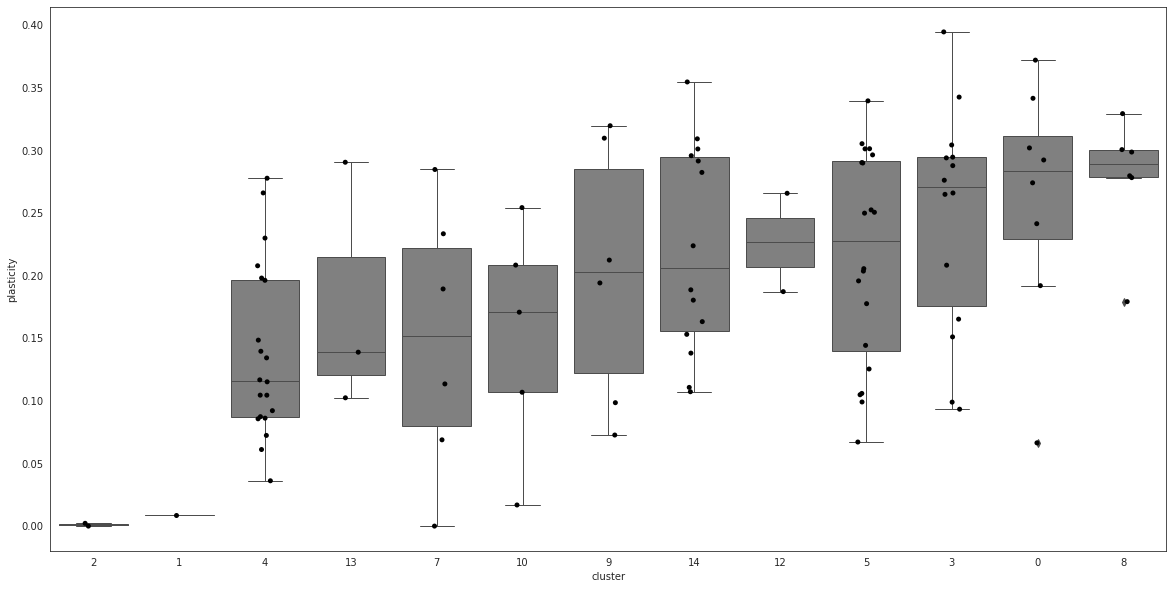

In [10]:
cluster_to_plasticities = pd.DataFrame(columns = ['cluster', 'plasticity', 'genotype', 'tumor'])
tumor_sizes = adata.obs['Tumor'].value_counts()
for cluster, g in adata.obs.groupby("leiden_sub"):
        
    indices = g.index.values
    indices = np.intersect1d(indices, plasticity_indices.index)
    vals = []
    genotypes = []
    tumors = []
    
    for tumor, g2 in g.loc[indices].groupby('Tumor'):
        if tumor != 'nan' and 'Normal' not in tumor and tumor.split("_")[2][0] == 'T' and g2.shape[0] and tumor_sizes.loc[tumor] > 100:
            vals.append(plasticity_indices.loc[g2.index.values, 'scPlasticity'].mean())
            genotypes.append(adata.obs.loc[adata.obs['Tumor'] == tumor, 'genotype'].values[0])
            tumors.append(tumor)

    _df = pd.DataFrame([[int(cluster)]*len(vals), vals, genotypes, tumors], index=['cluster', 'plasticity', 'genotype', 'tumor']).T
    cluster_to_plasticities = pd.concat([cluster_to_plasticities, _df])

cluster_to_mean_plasticity = {}
for cluster, g in cluster_to_plasticities[cluster_to_plasticities['genotype'] == 'sgNT'].groupby('cluster'):
    cluster_to_mean_plasticity[cluster] = g['plasticity'].median()
    
cluster_order = pd.DataFrame.from_dict(cluster_to_mean_plasticity, orient='index', columns = ['plasticity']).sort_values(by='plasticity', ascending=True).index


h = plt.figure(figsize=(20, 10))
sns.set_style("white")
sns.boxplot(x = 'cluster', y="plasticity", color='grey',
                    data=cluster_to_plasticities, order=cluster_order,
                    linewidth = 1)
sns.stripplot(x = 'cluster', y="plasticity",
                    data=cluster_to_plasticities,
                    order=cluster_order, color='black')
plt.show()

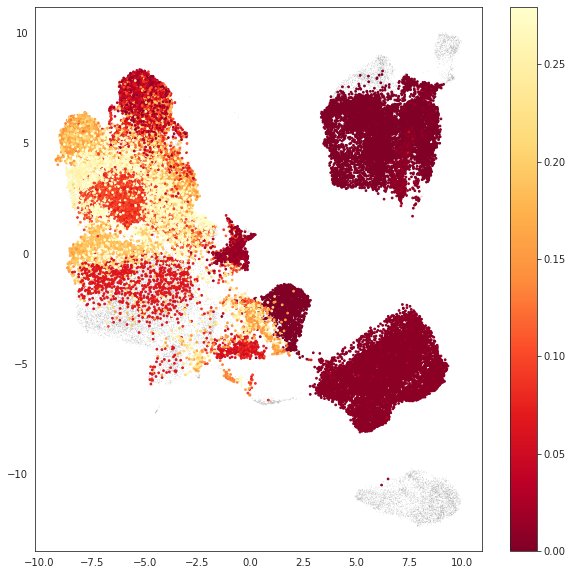

In [152]:
umap = pd.DataFrame(adata.obsm['X_umap'], index = adata.obs_names, columns = ['D1', 'D2'])

leaves = np.intersect1d(adata.obs_names, plasticity_indices.index)
bg = np.setdiff1d(adata.obs_names, leaves)

p = plasticity_indices.loc[leaves, 'scPlasticity']
vmin = np.percentile(p.values, 5)
vmax = np.percentile(p.values, 95)

fig = plt.figure(figsize=(10, 10))
plt.scatter(umap.loc[bg, 'D1'], umap.loc[bg, 'D2'], color='gray', s=0.01, alpha=0.4)
plt.scatter(umap.loc[leaves, 'D1'], umap.loc[leaves, 'D2'], c=p.values, s=3, cmap='YlOrRd_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

### Comparison of alternative plasticity indices - Figures S3C-H

In [126]:
kii = np.intersect1d(plasticity_indices.index.values, adata.obs_names)
adata.obs.loc[kii, 'scPlasticity'] = plasticity_indices.loc[kii, 'scPlasticity']
adata.obs.loc[kii, 'scPlasticityL2'] = plasticity_indices.loc[kii, 'scPlasticityL2']
adata.obs.loc[kii, 'scPlasticityAllele'] = plasticity_indices.loc[kii, 'scPlasticityAllele']

tumor_to_plasticities = adata.obs.groupby('Tumor').agg({"scPlasticity": 'mean', 'scPlasticityL2': 'mean', 'scPlasticityAllele': 'mean'})
tumor_to_plasticities = tumor_to_plasticities[~tumor_to_plasticities['scPlasticity'].isna()]

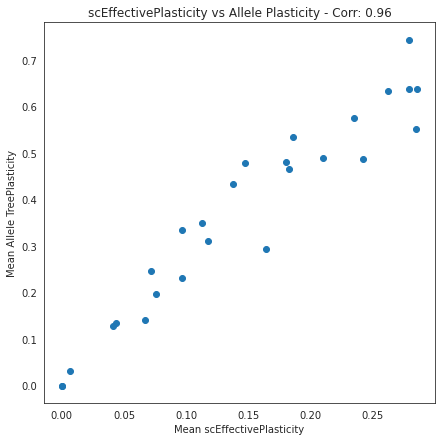

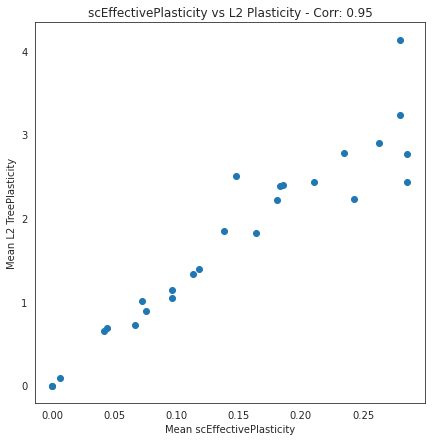

In [127]:
corr = round(scipy.stats.pearsonr(tumor_to_plasticities['scPlasticity'], tumor_to_plasticities['scPlasticityAllele'])[0],2)
fig = plt.figure(figsize = (7,7))

plt.scatter(tumor_to_plasticities['scPlasticity'], tumor_to_plasticities['scPlasticityAllele'])
plt.xlabel("Mean scEffectivePlasticity")
plt.ylabel("Mean Allele TreePlasticity")
plt.title(f'scEffectivePlasticity vs Allele Plasticity - Corr: {corr}')
plt.show()

corr = round(scipy.stats.pearsonr(tumor_to_plasticities['scPlasticity'], tumor_to_plasticities['scPlasticityL2'])[0], 2)

fig = plt.figure(figsize = (7,7))
plt.scatter(tumor_to_plasticities['scPlasticity'], tumor_to_plasticities['scPlasticityL2'])
plt.xlabel("Mean scEffectivePlasticity")
plt.ylabel("Mean L2 TreePlasticity")
plt.title(f'scEffectivePlasticity vs L2 Plasticity - Corr: {corr}')
plt.show()

Text(0.5, 1.0, 'scEffectivePlasticity vs L2 Plasiticity - corr: 0.69')

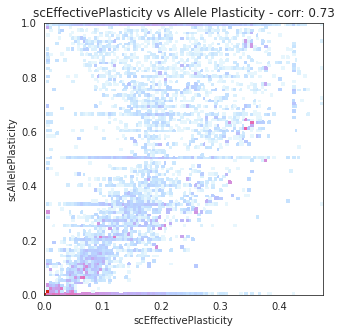

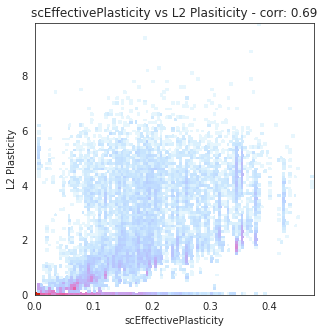

In [128]:
corr = round(scipy.stats.pearsonr(plasticity_indices['scPlasticity'], plasticity_indices['scPlasticityAllele'])[0],2)

fig = plt.figure(figsize=(5,5))
hist = plt.hist2d(plasticity_indices["scPlasticity"], plasticity_indices["scPlasticityAllele"], bins=[100,100], cmap=cc.cm.CET_L19, norm=mpl.colors.LogNorm())
plt.xlabel("scEffectivePlasticity")
plt.ylabel("scAllelePlasticity")
plt.title(f'scEffectivePlasticity vs Allele Plasticity - corr: {corr}')

corr = round(scipy.stats.pearsonr(plasticity_indices['scPlasticity'], plasticity_indices['scPlasticityL2'])[0],2)

fig = plt.figure(figsize=(5,5))
hist = plt.hist2d(plasticity_indices["scPlasticity"], plasticity_indices["scPlasticityL2"], bins=[100,100], cmap=cc.cm.CET_L19, norm=mpl.colors.LogNorm())
plt.xlabel("scEffectivePlasticity")
plt.ylabel("L2 Plasticity")
plt.title(f'scEffectivePlasticity vs L2 Plasiticity - corr: {corr}')

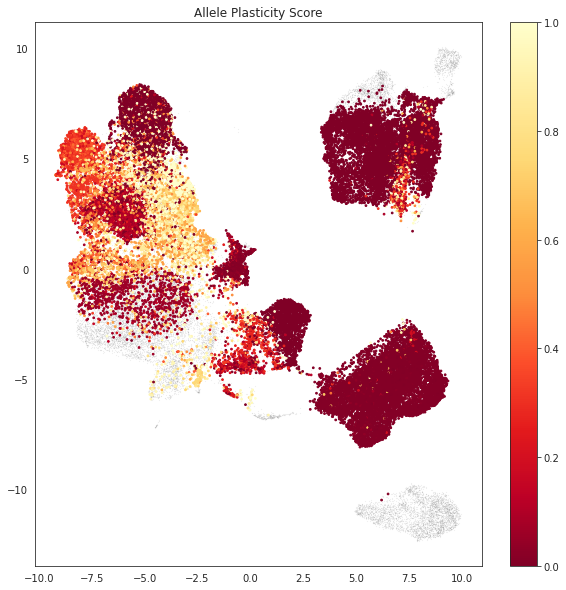

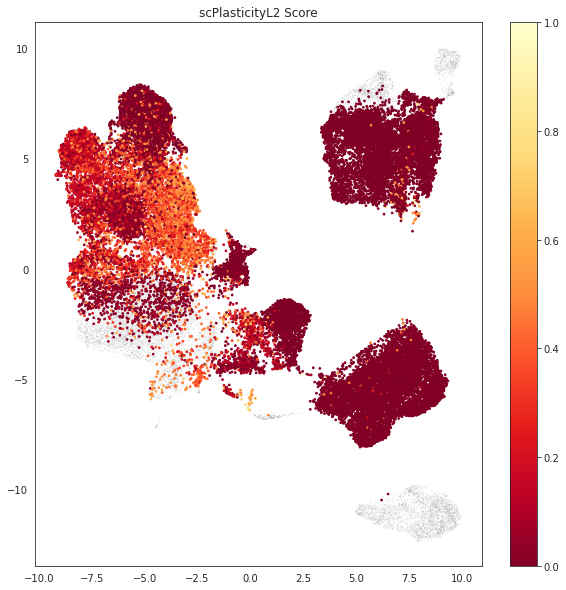

In [91]:
p = pd.DataFrame(plasticity_indices.loc[leaves, 'scPlasticityAllele'].values,  columns=['plasticity'])
_mi, _ma = p.min(), p.max()
p['plasticity'] = p.apply(lambda x: (x.plasticity-_mi) / (_ma - _mi), axis=1)

p = p['plasticity']

vmin = np.percentile(p, 10)
vmax = np.percentile(p, 100)

fig = plt.figure(figsize=(10, 10))
plt.scatter(umap.loc[bg, 'D1'], umap.loc[bg, 'D2'], color='gray', s=0.01, alpha=0.4)
plt.scatter(umap.loc[leaves, 'D1'], umap.loc[leaves, 'D2'], c=p, s=3, cmap='YlOrRd_r')
plt.colorbar()
plt.title("Allele Plasticity Score")
plt.show()

p = pd.DataFrame(plasticity_indices.loc[leaves, 'scPlasticityL2'].values,  columns=['plasticity'])
_mi, _ma = p.min(), p.max()
p['plasticity'] = p.apply(lambda x: (x.plasticity-_mi) / (_ma - _mi), axis=1)

p = p['plasticity']

vmin = np.percentile(p, 10)
vmax = np.percentile(p, 100)

fig = plt.figure(figsize=(10, 10))
plt.scatter(umap.loc[bg, 'D1'], umap.loc[bg, 'D2'], color='gray', s=0.01, alpha=0.4)
plt.scatter(umap.loc[leaves, 'D1'], umap.loc[leaves, 'D2'], c=p, s=3, cmap='YlOrRd_r')
plt.colorbar()
plt.title("scPlasticityL2 Score")
plt.show()

### Compare leiden fitnesses vs plasticities - Figure S3J

In [153]:
leiden_to_plasticity = {}
leiden_to_fitness = {}

for leiden, grp in tqdm(adata.obs.groupby('leiden_sub')):
    
    fitness_averages = []
    plasticity_averages = []
    for tumor, grp2 in grp.groupby("Tumor"):
    
        cells = grp2.index.values
        cells = np.intersect1d(plasticity_indices.index.values, cells)

        cells = np.intersect1d(sigscores.index, cells)
        
        if len(cells) > 0:
            fitness_averages.append(sigscores.loc[cells, 'FitnessSignature'].mean())
            plasticity_averages.append(plasticity_indices.loc[cells, 'scPlasticity'].mean())
    
    leiden_to_plasticity[leiden] = np.mean(plasticity_averages)
    leiden_to_fitness[leiden] = np.mean(fitness_averages)

    
leiden_to_plasticity = pd.DataFrame.from_dict(leiden_to_plasticity, orient='index')
leiden_to_fitness = pd.DataFrame.from_dict(leiden_to_fitness, orient='index')

  0%|          | 0/15 [00:00<?, ?it/s]

/home/eecs/mattjones/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eecs/mattjones/.local/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [154]:
# transform to be between 0 and 1
for column in leiden_to_plasticity:
    
    _mi, _ma = leiden_to_plasticity[column].min(), leiden_to_plasticity[column].max()
    leiden_to_plasticity[column] = leiden_to_plasticity[column].apply(lambda x: (x - _mi) / (_ma - _mi))
    
for column in leiden_to_fitness:
    
    _mi, _ma = leiden_to_fitness[column].min(), leiden_to_fitness[column].max()
    leiden_to_fitness[column] = leiden_to_fitness[column].apply(lambda x: (x - _mi) / (_ma - _mi))

Text(0.5, 1.0, 'Fitness vs Plasticity of Leiden Clusters')

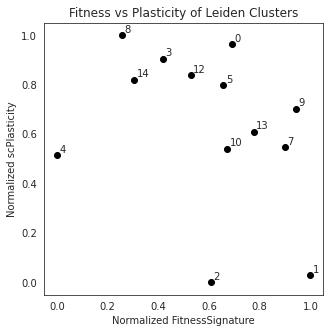

In [155]:
fig = plt.figure(figsize=(5,5))
plt.scatter(leiden_to_fitness.loc[leiden_to_plasticity.index].values, leiden_to_plasticity.values, color='black')
plt.xlabel("Normalized FitnessSignature")
plt.ylabel("Normalized scPlasticity")

for label in leiden_to_fitness.index:
    
    plt.annotate(label, (leiden_to_fitness.loc[label] + 0.01, leiden_to_plasticity.loc[label] + 0.01))

plt.title("Fitness vs Plasticity of Leiden Clusters")

### Single-cell Fitness Signature vs Plasticity -- Figure S3I

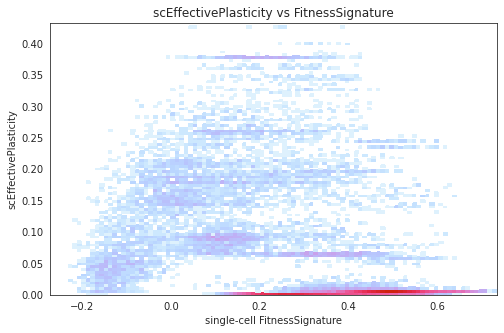

In [98]:
kii = np.intersect1d(plasticity_indices.index, sigscores.index)

fig = plt.figure(figsize=(8,5))
hist = plt.hist2d(sigscores.loc[kii, "FitnessSignature"], plasticity_indices.loc[kii, "scPlasticity"], bins=[100,100], cmap=cc.cm.CET_L19, norm=mpl.colors.LogNorm())
plt.ylabel("scEffectivePlasticity")
plt.xlabel("single-cell FitnessSignature")
plt.title(f'scEffectivePlasticity vs FitnessSignature')
plt.show()